In [1]:
from joblib import dump, load
import os
import string
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import Ridge, GammaRegressor

# PyTorch stuff
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

# Autoselect target device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

from timeit import default_timer as timer
from datetime import timedelta

os.chdir('/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/nlp-group-project-main/nvdm')
from models import nvdm

Using device cuda


# Helper Functions
## Text Processor

In [2]:
# Instance of Lemmatizer
LEMMATIZER = WordNetLemmatizer()
STOPWORDS = stopwords.words('english')

def preprocess_text(text):
    """ Process a single line of text. """

    # Strip trailing characters if any (e.g. newline)
    text_new = text.strip()
    
    # Remove puncuation
    text_new = ''.join(ch for ch in text_new if ch not in string.punctuation)

    # Lower case
    text_new = text_new.lower()
    
    # Tokenise by space
    tokens = text_new.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in STOPWORDS]

    # Lemmatise each word
    tokens = [LEMMATIZER.lemmatize(word) for word in tokens]
    
    text_new = ' '.join(tokens)

    return text_new

## Model Wrapper

In [3]:
class Model:
    """ Base class for clustering models.
    
    Basically a wrapper for a variety of models.
    """
    def __init__(self):
        pass
    
    def fit(self, X):
        """ Train the model. """
        raise NotImplementedError()
    
    def transform(self, X):
        """ Apply model to new data.
        
        Should output a topic-document matrix,
        where each element is a score indicating how likely the document
        should be assigned to the topic.
        For sklearn LDA, transform() does this by default.
        """
        raise NotImplementedError()

    @property
    def topic_vocab_matrix(self):
        """ Each model should be able to return a topic-vocab matrix
        containing a score (e.g. probability) of a word in the vocabulary
        occuring in the k^th topic. """
        pass
    
    # TODO: topic-document matrix
    # TODO: perplexity? Don't think K-Means has a notion of perplexity
    # (because we need probabilities).

    
class KMeansModel(Model):
    """ Wrapper for scikit-learn KMeans. """
    def __init__(self, num_topics):
        self.model = KMeans(
            n_clusters = num_topics,
            init='k-means++',
            max_iter = 300,
            n_init = 10,
            verbose = False)
    
    def fit(self, X):
        self.model.fit(X)

    def transform(self, X):
        """ Returns a topic-document matrix of distances per cluster. """
        return -self.model.transform(X)
    
    @property
    def topic_vocab_matrix(self):
        """ Return K-Means clusters.
        
        ndarray of shape (num_topics, n_features)
        """
        return self.model.cluster_centers_


class LDAModel(Model):
    """ Wrapper for scikit-learn LDA. """
    def __init__(self, num_topics):
        self.model = LatentDirichletAllocation(
            n_components=num_topics,
            max_iter=5,
            learning_method='online',
            learning_offset=50.,
            n_jobs=-1)
    
    def fit(self, X):
        self.model.fit(X)
    
    def transform(self, X):
        """ Returns a topic-document matrix of probabilities. """
        return self.model.transform(X) 
    
    @property
    def topic_vocab_matrix(self):
        """ Gets the components_ attribute of LDA, normalized
        
        Quoting sklearn docs:
        Variational parameters for topic word distribution.
        Since the complete conditional for topic word distribution is a Dirichlet,
        components_[i, j] can be viewed as pseudocount that represents
        the number of times word j was assigned to topic i.
        It can also be viewed as distribution over the words for each topic after normalization:
        model.components_ / model.components_.sum(axis=1)[:, np.newaxis].
        """
        # return self.model.components_
        return self.model.components_ / self.model.components_.sum(axis=1)[:, np.newaxis]

class NVDMModel(Model):
    """ PyTorch NVDM model.
    
    Loads a pretrained model from disk.
    """
    def __init__(self, model_path, vocab_size, hidden_size=500, num_topics=300):
        self.model = NVDM(vocab_size, hidden_size, num_topics, 1, "cpu")
        self.model.load_state_dict(torch.load(model_path, map_location="cpu"))
        self.model.eval()
        
        decoder = self.model.decoder[0]
        weights = decoder.weight.data.detach().clone().cpu().numpy()
        self.topic_vocab = weights.T
    
    def fit(self, X):
        """ We don't train the model here because it takes too long. """
        pass
    
    def transform(self, X):
        """ Output a topic-document matrix. """
        n_doc, n_vocab = X.shape
        n_topic = self.topic_vocab.shape[0]
        
        # shape (n_doc, n_topic)
        # Score of each document for a topic is the average scores
        # of the document's words in the topic.
        topic_doc = X @ self.topic_vocab.T
        
        # Optionally, normalize by document length.
        topic_doc = topic_doc / X.sum(axis=1, keepdims=True)
        
        return topic_doc
    
    @property
    def topic_vocab_matrix(self):
        """ Returns the learned semantic embeddings of each word. """
        return self.topic_vocab

## Evaluation

In [17]:
# Topic coherence.
def umass_score(tf):
    """ Compute topic coherence using UMass metric.
    
    Ref: http://qpleple.com/topic-coherence-to-evaluate-topic-models/
    
    tf: term-frequency matrix for each document.
        Each i^th row is the BOW representation of the i^th document.
    """
    
    # D(wi): count of documents containing the word wi (i.e. df)
    Dwi = np.array(np.sum(tf > 0, axis=0))

    W_bin = np.zeros_like(tf)
    W_bin[tf > 0] = 1
    
    # D(wi, wj): count of documents containing both words wi and wj
    Dwi_wj = W_bin.T @ W_bin

#     score_umass = np.log((Dwi_wj + 1)/ (Dwi + 1))
    score_umass = np.log((Dwi_wj + 1)/ (Dwi))
    
    return score_umass

def topic_coherence(topic_vocab, n_top_words, pair_score):
    """ Compute the topic coherence of each topic,
    given a learned topic-vocabulary matrix, the number of top words to use
    and a matrix of pairwise scores (e.g. umass_score output)
    
    topic_vocab: dimensions (number of topics, vocabulary size).
    model.components_ for LDA, and the "semantic embedding" matrix in the decoder for NVDM.
    
    pair_score: matrix of scores (e.g. UMass)
    """
    coherences = []
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        coh = 0
        for i in range(len(top_features_ind)):
            for j in range(i):
                coh += pair_score[top_features_ind[i], top_features_ind[j]]
        coherences.append(coh)
    return coherences

def plot_top_words(topic_vocab, feature_names, n_top_words, title):
    """ Given a topic-vocabulary matrix containing scores
    (e.g. probabilities, higher the better),
    plot the top words as a frequency bar-graph for each topic.
    
    e.g. set topic_vocab=model._components for LDA.
    """
    K = len(topic_vocab)
    n_x = 5
    n_y = int(np.ceil(K / n_x))
    fig, axes = plt.subplots(n_y, n_x, figsize=(2.5 * n_x, 4 * n_y), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(topic_vocab):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 14})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=20)

    # plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    
    fig.tight_layout()
    plt.show()
    
    
def daily_adjusted_r2(returns, features):
    """
    Takes in a dates by stocks matrix (T x M) of stock returns and a stocks by features matrix (M x K) 
    of features.
    
    Loops over dates. On each date, performs a OLS regression of M stock returns against a M x (K + 1) matrix
    of features, including an intercept which has been added. Then records the adjusted R2 of that regression
    on that date.
    
    Outputs a dataframe of length T of R2 values.
    """
    all_dates = returns.index
    adj_r2 = []

    for dd in all_dates:
        # removing features we don't have returns for
        reg_data = returns.loc[[dd]].transpose().join(features).dropna(axis=0).values
        y = reg_data[:, 0]
        X = reg_data[:, 1:]

        std_scaler = StandardScaler()
        X = std_scaler.fit_transform(X)

        X = sm.add_constant(X, prepend=False)
        ols_model = sm.OLS(y, X)
        res = ols_model.fit()
        adj_r2.append(res.rsquared_adj)
    return pd.DataFrame(index=all_dates, data=adj_r2)


def cv_score_ridge(dependent, features):
    trials = 200
    alphas = [0.01, 0.1, 1, 10, 100, 200, 500, 1000]
    best_score = 0
    stdev_best = 0
    alpha_best = 0
    for alpha in alphas:
        res_alpha = []
        for _ in range(trials):
            X_train, X_test, y_train, y_test = train_test_split(features, dependent)
            my_regression = Ridge(alpha=alpha)
            std_scaler = StandardScaler()
            X_train = std_scaler.fit_transform(X_train)
            X_test = std_scaler.transform(X_test)
            my_regression.fit(X_train, y_train)
            res_alpha.append(my_regression.score(X_test, y_test))
        if np.mean(res_alpha) > best_score:
            best_score = np.mean(res_alpha)
            stdev_best = np.std(res_alpha)
            alpha_best = alpha
    return best_score, stdev_best, alpha_best


def cv_score_gamma(dependent, features):
    trials = 200
    alphas = [0.01, 0.1, 1, 10, 100, 200, 500, 1000]
    best_score = 0
    stdev_best = 0
    alpha_best = 0
    for alpha in alphas:
        res_alpha = []
        for _ in range(trials):
            X_train, X_test, y_train, y_test = train_test_split(features, dependent)
            my_regression = GammaRegressor(alpha=alpha)
            std_scaler = StandardScaler()
            X_train = std_scaler.fit_transform(X_train)
            X_test = std_scaler.transform(X_test)
            my_regression.fit(X_train, y_train)
            res_alpha.append(my_regression.score(X_test, y_test))
        if np.mean(res_alpha) > best_score:
            best_score = np.mean(res_alpha)
            stdev_best = np.std(res_alpha)
            alpha_best = alpha
    return best_score, stdev_best, alpha_best  

## Data Loaders

In [6]:
def load_sp500(path, preprocess=False):
    """ Load S&P500 data from the per-company text files in the supplied directory path.
    
    Within the directory, each file is named "<ticker>_<sector>.txt".
    Each contains the business description (BD) of the company.
    
    If preprocess is True, the preprocess the business descriptions at the same time.
    """
    filenames = os.listdir(path)

    tickers = []
    sectors = []
    bds = []
    for fn in filenames:
        prefix = fn.split('.txt')[0]
        ticker, sector = prefix.split('_')
        filepath = os.path.join(path, fn)
        with open(filepath, 'r', encoding="utf8") as f:
            bd = f.read().strip()
        
        if preprocess:
            bd = preprocess_text(bd)

        tickers.append(ticker)
        sectors.append(sector)
        bds.append(bd)
    
    return tickers, sectors, bds


def load_bds1(path, preprocess=False, exclude_tickers=None):
    """ Load data from the business data, given the file path (e.g. "data/bds_1.txt").
    
    In the file, each company has two consecutive lines.
    The first line is <company ticker>:<CIK> (we only care about the ticker)
    and the second line is the company business description.
    
    exclude_tickers is a list of tickers that we want to ignore in bds_1.txt.
    For example, we can use this to exclude any S&P500 companies to avoid
    overlapping of datasets.
    """
    
    with open(path, "r", encoding="utf8") as f:
        lines = f.readlines()

    company_ids_all = [ln.strip() for ln in lines[0::2]]
    company_descriptions_all = [ln.strip() for ln in lines[1::2]]
    company_tickers = [x.split(':')[0] for x in company_ids_all]

    exclusion_set = set(exclude_tickers) if exclude_tickers is not None else set()

    tickers = []
    bds = []
    
    # Some business descriptions are too short (or even empty),
    # so we only keep those with a length (number of characters) deemed reasonable.
    bd_valid_length = 3000
    for ticker, bd in zip(company_tickers, company_descriptions_all):
        if ticker not in exclusion_set and len(bd) >= bd_valid_length:
            tickers.append(ticker)
            
            if preprocess:
                bd = preprocess_text(bd)
            bds.append(bd)
    
    return tickers, bds


def load_returns(path, tickers, start_d=np.datetime64('2018-01-01'), end_d=np.datetime64('2020-01-01')):
    """
    Loads price data from path, between a set of dates and converts to daily log returns. 
    
    Data only available for S&P 500 stocks that were in index over past 20 years. Supply list of tickers to 
    subset this.
    
    Example path:
    '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/MarketData/Price.csv'
    
    Please install Pandas library to get working (pip install pandas)
    """
    
    # loads    
    price_data = pd.read_csv(path)
    
    # subset desired tickers from price file
    select_these = np.in1d(price_data.tic.values, list(tickers))
    
    # price file stored columns wise. Select columns we want.
    price_sp50 = price_data.loc[select_these, ['tic', 'datadate', 'prccd']]
    
    # format dates to use pandas date handling
    price_sp50['datadate'] = pd.to_datetime(price_sp50['datadate'], format='%Y%m%d')
    
    # pivot to dates by stocks table
    price_sp50 = pd.pivot_table(price_sp50,index='datadate',columns='tic',values='prccd')
    
    # fill in missing prices so we can calculate returns over holidays
    price_sp50 = price_sp50.ffill(limit=5)
    
    # subset business days only
    business_ds = pd.date_range(start_d, end_d, freq='B')
    price_sp50 = price_sp50.reindex(business_ds)
    price_sp50 = price_sp50.loc[~np.all(np.isnan(price_sp50.values), axis=1), :]
    
    # remove stocks with missing data
    price_sp50 = price_sp50.dropna(axis=1)
    
    # we now have a continuous price series for all stocks. We convert these into changes in price, 
    # i.e. log returns. Logs used as dampens outliers for subsequent OLS regression.
    returns_sp50 = np.log(price_sp50) - np.log(price_sp50.shift(1))
    return returns_sp50.dropna(axis=0)

# Load Data

In [7]:
sp500_path = '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/SP500'
sp500_tickers, sp500_sectors, sp500_bds = load_sp500(sp500_path, preprocess=True)

bds1_path = '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/bds_1.txt'
bds1_tickers, bds1_bds = load_bds1(bds1_path, preprocess=True, exclude_tickers=sp500_tickers)

stock_returns_path = '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/MarketData/Price.csv'
sp500_returns = load_returns(stock_returns_path, sp500_tickers)

/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (1,4) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [8]:
total_returns = pd.DataFrame(sp500_returns.mean(axis=0))
total_returns.columns = ['returns']
total_stdev = pd.DataFrame(sp500_returns.std(axis=0))
total_stdev.columns = ['stdev']

# Extract Text Features

In [9]:
n_features = 4000
tf_vectorizer = CountVectorizer(max_features=n_features, max_df=0.95, min_df=2)
tf_vectorizer.fit(bds1_bds)

CountVectorizer(max_df=0.95, max_features=4000, min_df=2)

In [10]:
X_sp500 = tf_vectorizer.transform(sp500_bds).toarray()
X_bds = tf_vectorizer.transform(bds1_bds).toarray()

um_score_bds = umass_score(X_bds)

# Setting up NVDM Model

In [10]:
class BDDataset(Dataset):
    """ Very simple dataset object. Stores all the passages.
    
    This is just for compatibility with PyTorch DataLoader.
    """
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [11]:
dataset = BDDataset(torch.tensor(X_sp500, dtype=torch.float32))
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
hidden_size = 250

In [12]:
# training loop
def train(model, data_loader, outer_epochs=1000, print_every=100, device="cpu"):

    # Trains both the encoder and decoder at the same time.
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    start_time = timer()
    print("Start training...")


    for epoch in range(outer_epochs):

        loss_sum = 0.0
        rec_sum = 0.0
        kl_sum = 0.0
        n = len(data_loader)

        for text in data_loader:
            text = text.to(device)

            optimizer.zero_grad()
            loss_dict = model(text, kl_weight=1.0)
            loss = loss_dict["total"].sum()
            loss.backward()

            optimizer.step()

            # For printing
            loss_sum += loss.item()
            rec_sum += loss_dict["rec"].sum().item()
            kl_sum += loss_dict["kl"].sum().item()

        if (epoch + 1) % print_every == 0:
            print(f"[Time: {timedelta(seconds=timer() - start_time)}, Epoch {epoch + 1}] Loss {loss_sum/n}, Rec {rec_sum/n}, KL {kl_sum/n}")

# Choosing K For K Means

In [22]:
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 100]
tc_values_km = []
r2_stdev_results_km = []
r2_returns_results_km = []

runs = 200
for k in k_values:
    print(f'running k = {k}')
    this_c = []
    this_r2_returns = []
    this_r2_stdev = []
    for run in range(runs):
        # build model
        kmean = KMeansModel(k)
        kmean.fit(X_bds)
        
        # calculate coherence
        this_c.append(np.median(topic_coherence(kmean.topic_vocab_matrix, 10, um_score_bds)))
        
#         # work out adjusted r2 of return regression
#         features_sp500_df = pd.DataFrame(index=sp500_tickers, data=kmean.transform(X_sp500))
#         reg_data = total_returns.join(features_sp500_df)
#         y = reg_data.values[:, 0]
#         X = reg_data.values[:, 1:]
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#         best_alpha = cv_score_ridge(y_train, X_train)[2]
        
#         my_regression = Ridge(alpha=best_alpha)
#         std_scaler = StandardScaler()
#         X_train = std_scaler.fit_transform(X_train)
#         X_test = std_scaler.transform(X_test)
#         my_regression.fit(X_train, y_train)
#         this_r2_returns.append(my_regression.score(X_test, y_test))
        
#         # now adjusted D2 of risk regression
#         reg_data = total_stdev.join(features_sp500_df)
#         y = reg_data.values[:, 0]
#         X = reg_data.values[:, 1:]
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#         best_alpha = cv_score_gamma(y_train, X_train)[2]
        
#         my_regression = GammaRegressor(alpha=best_alpha)
#         std_scaler = StandardScaler()
#         X_train = std_scaler.fit_transform(X_train)
#         X_test = std_scaler.transform(X_test)
#         my_regression.fit(X_train, y_train)
#         this_r2_stdev.append(my_regression.score(X_test, y_test))
        
        
    tc_values_km.append(this_c)
    r2_stdev_results_km.append(this_r2_stdev)
    r2_returns_results_km.append(this_r2_returns)

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
running k = 15
running k = 20
running k = 25
running k = 30
running k = 35
running k = 40
running k = 45
running k = 50
running k = 60
running k = 70
running k = 80
running k = 100


In [23]:
results_folder = '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/Results/'
p_file = open(results_folder + 'KMeans_Coherence', 'wb')
pickle.dump(tc_values_km, p_file)
p_file.close()

# p_file = open(results_folder + 'KMeans_R2_Returns', 'wb')
# pickle.dump(r2_returns_results_km, p_file)
# p_file.close()

# p_file = open(results_folder + 'KMeans_R2_Risk', 'wb')
# pickle.dump(r2_stdev_results_km, p_file)
# p_file.close()

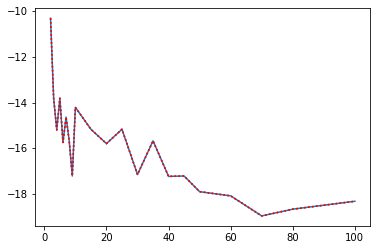

In [13]:
p_file = open(results_folder + 'KMeans_Coherence', 'rb')
tc_values_km = pickle.load(p_file)
p_file.close()

mu = np.mean(np.array(tc_values_km), axis=1)
ss = np.std(np.array(tc_values_km), axis=1)
plt.plot(k_values, mu)
plt.plot(k_values, mu + ss, 'r:')
plt.plot(k_values, mu - ss, 'r:')


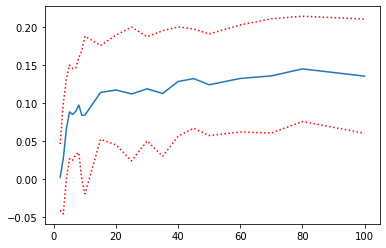

In [17]:
# p_file = open(results_folder + 'KMeans_R2_Risk', 'rb')
# r2_stdev_results_km = pickle.load(p_file)
# p_file.close()

mu = np.mean(np.array(r2_stdev_results_km), axis=1)
ss = np.std(np.array(r2_stdev_results_km), axis=1)
plt.plot(k_values, mu)
plt.plot(k_values, mu + ss, 'r:')
plt.plot(k_values, mu - ss, 'r:')

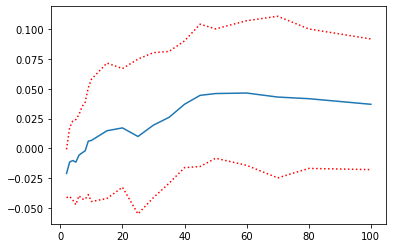

In [18]:
# p_file = open(results_folder + 'KMeans_R2_Returns', 'rb')
# r2_returns_results_km = pickle.load(p_file)
# p_file.close()

mu = np.mean(np.array(r2_returns_results_km), axis=1)
ss = np.std(np.array(r2_returns_results_km), axis=1)
plt.plot(k_values, mu)
plt.plot(k_values, mu + ss, 'r:')
plt.plot(k_values, mu - ss, 'r:')

# Choosing K for LDA
Here we fit a LDA model 20 times for different K values. Then, we look at the coherences and adjusted $R^2$ for different K.

In [24]:
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 100]
tc_values_lda = []
r2_stdev_results_lda = []
r2_returns_results_lda = []
perplex_lda = []
runs = 200
for k in k_values:
    print(f'running k = {k}')
    this_c = []
    this_r2_returns = []
    this_r2_stdev = []
    this_perplex = []
    for run in range(runs):
        # build model
        lda = LDAModel(k)
        lda.fit(X_bds)
        
        # calculate coherence
        this_c.append(np.median(topic_coherence(lda.topic_vocab_matrix, 10, um_score_bds)))
        
#         #perplexity
#         this_perplex.append(lda.model.perplexity(X_bds))
        
#         # work out adjusted r2 of return regression
#         features_sp500_df = pd.DataFrame(index=sp500_tickers, data=lda.transform(X_sp500))
#         reg_data = total_returns.join(features_sp500_df)
#         y = reg_data.values[:, 0]
#         X = reg_data.values[:, 1:]
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#         best_alpha = cv_score_ridge(y_train, X_train)[2]
        
#         my_regression = Ridge(alpha=best_alpha)
#         std_scaler = StandardScaler()
#         X_train = std_scaler.fit_transform(X_train)
#         X_test = std_scaler.transform(X_test)
#         my_regression.fit(X_train, y_train)
#         this_r2_returns.append(my_regression.score(X_test, y_test))
        
#         # now adjusted D2 of risk regression
#         reg_data = total_stdev.join(features_sp500_df)
#         y = reg_data.values[:, 0]
#         X = reg_data.values[:, 1:]
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#         best_alpha = cv_score_gamma(y_train, X_train)[2]
        
#         my_regression = GammaRegressor(alpha=best_alpha)
#         std_scaler = StandardScaler()
#         X_train = std_scaler.fit_transform(X_train)
#         X_test = std_scaler.transform(X_test)
#         my_regression.fit(X_train, y_train)
#         this_r2_stdev.append(my_regression.score(X_test, y_test))
        
    tc_values_lda.append(this_c)
    r2_stdev_results_lda.append(this_r2_stdev)
    r2_returns_results_lda.append(this_r2_returns)
    perplex_lda.append(this_perplex)

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
running k = 15
running k = 20
running k = 25
running k = 30
running k = 35
running k = 40
running k = 45
running k = 50
running k = 60
running k = 70
running k = 80
running k = 100


In [25]:
results_folder = '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/Results/'
p_file = open(results_folder + 'LDA_Coherence', 'wb')
pickle.dump(tc_values_lda, p_file)
p_file.close()

# p_file = open(results_folder + 'LDA_Perplexity', 'wb')
# pickle.dump(perplex_lda, p_file)
# p_file.close()

# p_file = open(results_folder + 'LDA_R2_Returns', 'wb')
# pickle.dump(r2_returns_results_lda, p_file)
# p_file.close()

# p_file = open(results_folder + 'LDA_R2_Risk', 'wb')
# pickle.dump(r2_stdev_results_lda, p_file)
# p_file.close()

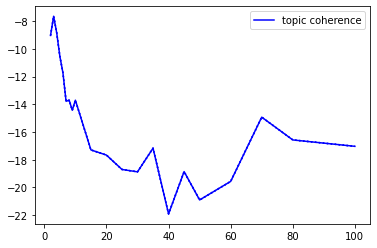

In [16]:
p_file = open(results_folder + 'LDA_Coherence', 'rb')
tc_values_lda = pickle.load(p_file)
p_file.close()

# p_file = open(results_folder + 'LDA_Perplexity', 'rb')
# perplex_lda = pickle.load(p_file)
# p_file.close()

mu_tc = np.mean(np.array(tc_values_lda), axis=1)
ss_tc = np.std(np.array(tc_values_lda), axis=1)

# mu_p = np.mean(np.array(perplex_lda), axis=1)
# ss_p = np.std(np.array(perplex_lda), axis=1)

plt.plot(k_values, mu_tc, 'b')
# plt.plot(k_values, mu_p, 'g')
plt.legend(['topic coherence', 'perplexity'])

plt.plot(k_values, mu_tc + ss_tc, 'b:')
plt.plot(k_values, mu_tc - ss_tc, 'b:')

# plt.plot(k_values, mu_p + ss_p, 'g:')
# plt.plot(k_values, mu_p - ss_p, 'g:')

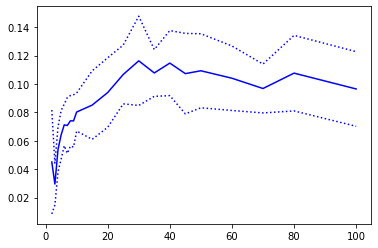

In [22]:
p_file = open(results_folder + 'LDA_R2', 'rb')
r2_stdev_results_lda = pickle.load(p_file)
p_file.close()

mu = np.mean(np.array(r2_stdev_results_lda), axis=1)
ss = np.std(np.array(r2_stdev_results_lda), axis=1)
plt.plot(k_values, mu, 'b')
plt.plot(k_values, mu + ss, 'b:')
plt.plot(k_values, mu - ss, 'b:')

# Choosing K for NVDM

In [23]:
def perplexity(model, dataset, n_sample, device="cpu"):
    """ Compute perplexity of PyTorch model on the PyTorch Dataset.
    
    If this gives a GPU/CPU error, try adding this before calling this function:
    
    model.device = "cpu"
    model = model.cpu()
    model.eval()
    """

    # Iterate over the whole dataset once (1 big batch).
    data_loader = DataLoader(dataset,
                             batch_size=len(dataset),
                             shuffle=False)
    assert len(data_loader) == 1

    for text in data_loader:
        text = text.to(device)

        with torch.no_grad():

            # Estimate the loss for each document by sampling
            loss_dict = model(text, kl_weight=1.0, n_sample=n_sample)
            loss = loss_dict["total"]

            # According to the NVDM paper, we estimate log probabilities using
            # the variational lower bound (negative of loss).
            log_probs = -loss

            # Perplexity below...
            
            # Length of each document is the sum of its bag-of-words vectpr
            doc_lengths = text.sum(dim=1)

            # Average over the words for each document
            ppx_doc = log_probs / doc_lengths

            # Perplexity: argument averages over documents
            ppx = torch.exp(-ppx_doc.mean()).item()

            return ppx

In [27]:
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 100]
epochs = 100
tc_values_nvdm = []
r2_stdev_results_nvdm = []
r2_returns_results_nvdm = []
perplex_nvdm = []
runs = 200
for k in k_values:
    print(f'running k = {k}')
    this_c = []
    this_r2_stdev = []
    this_r2_returns = []
    this_perplex = []
    for run in range(runs):
        # build model
        model_nvdm = nvdm.NVDM(n_features, hidden_size, k, 1, device)
        model_nvdm = model_nvdm.to(device)
        model_nvdm.train()
        train(model_nvdm, data_loader, outer_epochs=epochs, print_every=500, device=device)
        
        # calculate coherence
        decoder = model_nvdm.decoder[0]
        weights = decoder.weight.data.detach().clone().cpu().numpy()
        topic_vocab = weights.T
        this_c.append(np.median(topic_coherence(topic_vocab, 10, um_score_bds)))
        
        #perplexity
        pp = perplexity(model_nvdm, dataset, 20, device=device)
        this_perplex.append(pp)
        
        # work out adjusted r2 of return regression
        topic_doc = X_sp500 @ topic_vocab.T
        topic_doc = topic_doc / X_sp500.sum(axis=1, keepdims=True)
        
        features_sp500_df = pd.DataFrame(index=sp500_tickers, data=topic_doc)
        reg_data = total_returns.join(features_sp500_df)
        y = reg_data.values[:, 0]
        X = reg_data.values[:, 1:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        best_alpha = cv_score_ridge(y_train, X_train)[2]
        
        my_regression = Ridge(alpha=best_alpha)
        std_scaler = StandardScaler()
        X_train = std_scaler.fit_transform(X_train)
        X_test = std_scaler.transform(X_test)
        my_regression.fit(X_train, y_train)
        this_r2_returns.append(my_regression.score(X_test, y_test))
        
        # now adjusted D2 of risk regression
        reg_data = total_stdev.join(features_sp500_df)
        y = reg_data.values[:, 0]
        X = reg_data.values[:, 1:]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        best_alpha = cv_score_gamma(y_train, X_train)[2]
        
        my_regression = GammaRegressor(alpha=best_alpha)
        std_scaler = StandardScaler()
        X_train = std_scaler.fit_transform(X_train)
        X_test = std_scaler.transform(X_test)
        my_regression.fit(X_train, y_train)
        this_r2_stdev.append(my_regression.score(X_test, y_test))
        
    tc_values_nvdm.append(this_c)
    r2_stdev_results_nvdm.append(this_r2_stdev)
    r2_returns_results_nvdm.append(this_r2_returns)
    perplex_nvdm.append(this_perplex)

running k = 2
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training

Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start trai

Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start trai

Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
running k = 9
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training

Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start trai

Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start trai

Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start trai

Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
running k = 50
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start trainin

Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start trai

/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...
Start training...
Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...
Start training...
Start training...
Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...
Start training...
Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...
Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...
Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...
Start training...
Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...
Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...
Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...
Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status

Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


Start training...
Start training...


/home/lawrence/miniconda3/envs/comp0086_Exercises/lib/python3.8/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


In [28]:
results_folder = '/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data/Results/'
p_file = open(results_folder + 'NVDM_Coherence_' + str(epochs), 'wb')
pickle.dump(tc_values_nvdm, p_file)
p_file.close()

p_file = open(results_folder + 'NVDM_Perplexity_' + str(epochs), 'wb')
pickle.dump(perplex_nvdm, p_file)
p_file.close()

p_file = open(results_folder + 'NVDM_R2_Risk_' + str(epochs), 'wb')
pickle.dump(r2_stdev_results_nvdm, p_file)
p_file.close()

p_file = open(results_folder + 'NVDM_R2_Returns_' + str(epochs), 'wb')
pickle.dump(r2_returns_results_nvdm, p_file)
p_file.close()


In [ ]:
r2_returns_results_nvdm

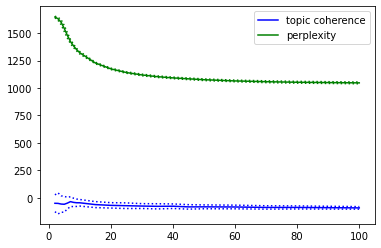

In [26]:
p_file = open(results_folder + 'NVDM_Coherence_' + str(epochs), 'rb')
tc_values_nvdm = pickle.load(p_file)
p_file.close()

p_file = open(results_folder + 'NVDM_Perplexity_' + str(epochs), 'rb')
perplex_nvdm = pickle.load(p_file)
p_file.close()

mu_tc = np.mean(np.array(tc_values_nvdm), axis=1)
ss_tc = np.std(np.array(tc_values_nvdm), axis=1)

mu_p = np.mean(np.array(perplex_nvdm), axis=1)
ss_p = np.std(np.array(perplex_nvdm), axis=1)

plt.plot(k_values, mu_tc, 'b')
plt.plot(k_values, mu_p, 'g')
plt.legend(['topic coherence', 'perplexity'])

plt.plot(k_values, mu_tc + ss_tc, 'b:')
plt.plot(k_values, mu_tc - ss_tc, 'b:')

plt.plot(k_values, mu_p + ss_p, 'g:')
plt.plot(k_values, mu_p - ss_p, 'g:')

In [ ]:
p_file = open(results_folder + 'NVDM_R2_' + str(epochs), 'rb')
r2_stdev_results_nvdm = pickle.load(p_file)
p_file.close()

mu = np.mean(np.array(r2_stdev_results_nvdm), axis=1)
ss = np.std(np.array(r2_stdev_results_nvdm), axis=1)
plt.plot(k_values, mu, 'b')
plt.plot(k_values, mu + ss, 'b:')
plt.plot(k_values, mu - ss, 'b:')

# Plotting Top Words

In [ ]:
lda_15 = LDAModel(15)
lda_15.fit(X_bds)
plot_top_words(lda_15.topic_vocab_matrix, tf_vectorizer.get_feature_names(), 10, "LDA 15")

In [ ]:
lda_5 = LDAModel(5)
lda_5.fit(X_bds)
plot_top_words(lda_5.topic_vocab_matrix, tf_vectorizer.get_feature_names(), 10, "LDA 5")

## K Means

In [ ]:
kmeans_15 = KMeansModel(15)
kmeans_15.fit(X_bds)
plot_top_words(kmeans_15.topic_vocab_matrix, tf_vectorizer.get_feature_names(), 10, "K Means 15")

In [ ]:
kmeans_5 = KMeansModel(5)
kmeans_5.fit(X_bds)
plot_top_words(kmeans_5.topic_vocab_matrix, tf_vectorizer.get_feature_names(), 10, "K Means 5")

## Stock Returns

In [ ]:
features_sp500_df = pd.DataFrame(index=sp500_tickers, data=lda_15.transform(X_sp500))
adj_r2_lda_15 = daily_adjusted_r2(sp500_returns, features_sp500_df)

features_sp500_df = pd.DataFrame(index=sp500_tickers, data=kmeans_5.transform(X_sp500))
adj_r2_kmeans_5 = daily_adjusted_r2(sp500_returns, features_sp500_df)

In [ ]:
font_size=15
plt.figure(figsize=[10, 8])
plt.plot(adj_r2_lda_15)
plt.plot(adj_r2_kmeans_5)
plt.xlabel('Date', fontsize=font_size)
plt.ylabel('Adjusted $R^2$', fontsize=font_size)
plt.title('Adjusted $R^2$ By Date', fontsize=font_size)
plt.legend(['LDA 15', 'K Means 5'], fontsize=font_size);

# Classifier

## LDA

In [ ]:
lda_5 = LDAModel(5)
lda_5.fit(X_bds)

features_sp500_lda5 = lda_5.transform(X_sp500)
X_train, X_test, y_train, y_test = train_test_split(features_sp500_lda5, sp500_sectors, test_size=0.33, random_state=420)

my_svc = SVC()
my_svc.fit(X_train, y_train)
_, ax = plt.subplots(figsize=[10, 10])
plot_confusion_matrix(my_svc, X_test, y_test, ax=ax)

In [ ]:
features_sp500_lda5 = lda_15.transform(X_sp500)
X_train, X_test, y_train, y_test = train_test_split(features_sp500_lda15, sp500_sectors, test_size=0.33, random_state=420)

my_svc = SVC(C=10)
my_svc.fit(X_train, y_train)
_, ax = plt.subplots(figsize=[10, 10])
plot_confusion_matrix(my_svc, X_test, y_test, ax=ax)